In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
from itertools import product

import numpy as np

from matplotlib import pyplot as plt
from astropy.table import Table

from stellarphot.analysis.transit_fitting import TransitModelFit
from graphing_functions import *

from astropy.timeseries import BinnedTimeSeries, TimeSeries, aggregate_downsample
from astropy.time import Time
from astropy.table import Table 
from astropy import units as u

### 0. Get some data

In [3]:
photometry = Table.read('updated-relative-flux-kelt-1.fits')

In [4]:
# Enter your object's period here
period = 1.217494 * u.day

# Enter the epoch here
epoch = Time(2456583.78435, scale='tdb', format='jd')

# Enter the duration below
duration = 2.55 * u.hour

# These affect spacing of lines on final plot
high = 1.06
low = 0.82
scale = 0.15 * (high - low)
shift = -.72 * (high - low)

phot_filter = 'r'

#bin size in minutes
bin_size = 5 * u.min

target_star = photometry['id'] == 1

# No changes to the line below, it is grabbing the first time in the data series
then = Time(photometry['BJD'][target_star][0], scale='tdb', format='jd')

Looks like we need to normalize the data first.....

In [5]:
band_filter = photometry['filter'] == phot_filter

target_and_filter = target_star & band_filter

In [6]:
photometry = photometry[target_and_filter]

In [7]:
cycle_number = np.int((then - epoch) / period + 1)
that_transit = cycle_number * period + epoch
that_transit

<Time object: scale='tdb' format='jd' value=2458413.677832>

In [8]:
start = that_transit - duration / 2
mid = that_transit
end = that_transit + duration / 2

after_transit = (photometry['BJD'] - 2400000) > end.jd

outside_transit = (photometry['BJD'] < start.jd) | (photometry['BJD'] > end.jd)

normalization_factor = np.nanmean(1 / photometry['relative_flux'][outside_transit])
normalized_flux = photometry['relative_flux'] * normalization_factor

### Bin Data

Need
* data table
* start
* end
* bin_size

In [9]:
t_ob = Time(photometry['BJD'], scale='tdb', format='jd')
ts = TimeSeries([normalized_flux, photometry['airmass'], photometry['xcenter'], photometry['sky_per_pix_avg'], photometry['width']], time=t_ob)
ts2 = TimeSeries([normalization_factor * photometry['relative_flux_error']], time=t_ob)

first_time =  photometry['BJD'][0] - 2400000
last_time = photometry['BJD'][-1] - 2400000

def add_quad(x):
    try:
        n = len(x)
    except TypeError:
        n = 1
    return np.sqrt(np.nansum(x**2)) / n

binned = aggregate_downsample(ts, time_bin_size=bin_size)
binned2 = aggregate_downsample(ts2, time_bin_size=bin_size, aggregate_func=add_quad)

#binned_time = BinnedTimeSeries(photometry['BJD'], time_bin_start=first_time, time_bin_end=last_time, time_bin_size=bin_size)

### 1. Create the model object

In [10]:
mod = TransitModelFit()

### 2. Load some data

Here we will just load times and normalized flux. You can also set width, spp (sky per pixel) and airmass. The only two that must be set are times and flux.

If you have set `mod.spp`, `mod.width` or `mod.airmass` then those things will be included in the fit. Otherwise, they are ignored.

THE WEIGHTS ARE IMPORTANT TO INCLUDE

In [11]:
not_empty = ~np.isnan(binned['relative_flux'])

mod.times = (np.array(binned['time_bin_start'].value) - 2400000)[not_empty]
mod.data = binned['relative_flux'].value[not_empty]
mod.weights = 1 / (binned2['relative_flux_error'].value)[not_empty]



### 3. Set up the model

You should be able to get the parameters for this from TTF. There are more parameters you can set; `shift-Tab` in the arguments to pull up the docstring, which lists and explains them all.

In [12]:
mod.setup_model(t0=mid.jd - 2400000,         # midpoint, BJD
                depth=5.993856,       # parts per thousand
                duration=duration.to('day').value,  # days
                period=period.to('day').value,    # days
               )

### 3.25 Set up airmass, etc

In [13]:
mod.airmass = np.array(binned['airmass'])[not_empty]
mod.width = np.array(binned['width'])[not_empty]
mod.spp = np.array(binned['sky_per_pix_avg'])[not_empty]

### 3.5 👉👉👉 Constrain the fits if you want 👈👈👈

#### Exoplanet parameters

In [14]:
#mod.model.t0.bounds = [mid - 0.01, mid + 0.01]
mod.model.t0.fixed = True
# mod.model.a.fixed = True
# mod.model.rp.fixed = True



#### Detrending parameters

In [15]:
mod.model.spp_trend.fixed = True
mod.model.airmass_trend.fixed = True
mod.model.width_trend.fixed = True

### 4. Run the fit

In [16]:
mod.fit()

### 5. Let's try a plot....

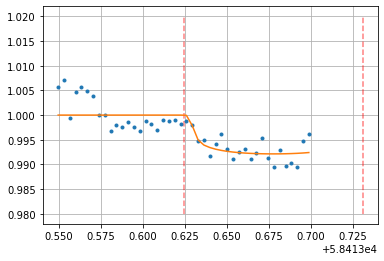

In [17]:
plt.plot(mod.times, mod.data, '.')
plt.plot(mod.times, mod.model_light_curve())
plt.vlines(start.jd - 2400000, 0.98, 1.02, colors='r', linestyle='--', alpha=0.5)
plt.vlines(end.jd - 2400000, 0.98, 1.02, colors='r', linestyle='--', alpha=0.5)
plt.grid()

In [18]:
mod.model

<transit_model_with_trends(t0=58413.677832, period=1.217494, rp=0.08172104, a=4.0705872, inclination=90., eccentricity=0., limb_u1=0.3, limb_u2=0.3, airmass_trend=0., width_trend=0., spp_trend=0.)>

In [19]:
# mod._fitter.fit_info

In [20]:
flux_full_detrend = mod.data_light_curve(detrend_by='all') 
flux_full_detrend_model = mod.model_light_curve(detrend_by='all') 

In [21]:
rel_detrended_flux = flux_full_detrend / np.mean(flux_full_detrend)

rel_detrended_flux_rms = np.std(rel_detrended_flux)
rel_model_rms = np.std(flux_full_detrend_model - rel_detrended_flux)

rel_flux_rms = np.std(mod.data)

In [22]:
airmass = photometry['airmass'] / np.mean(photometry['airmass'])
x = photometry['xcenter'] / np.mean(photometry['xcenter'])
y = photometry['ycenter'] / np.mean(photometry['ycenter'])
comp_counts = photometry['comparison counts'] / np.mean(photometry['comparison counts'])
sky_per_pix = photometry['sky_per_pix_avg'] / np.mean(photometry['sky_per_pix_avg'])
width = photometry['width'] / np.mean(photometry['width'])

In [23]:
scale_airmass = scale_and_shift(airmass, scale, 0.75 * shift, pos=False)
scale_x = scale_and_shift(x, scale, shift, pos=True)
scale_y = scale_and_shift(y, scale, shift, pos=True)
scale_sky_pix = scale_and_shift(sky_per_pix, scale, shift, pos=True)
scale_counts = scale_and_shift(comp_counts, scale, shift, pos=True)
scale_width = scale_and_shift(width, scale, shift, pos=True)

In [24]:
grid_y_ticks = np.arange(low, high, 0.02)

<Figure size 576x792 with 0 Axes>

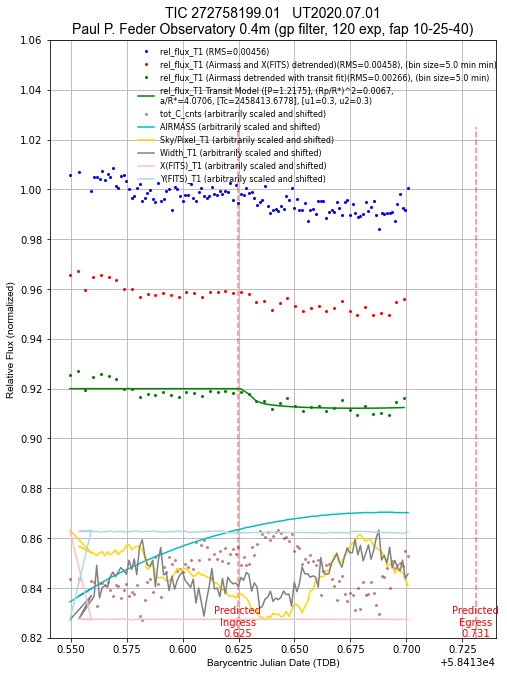

In [25]:
#(RMS={rel_flux_rms:.5f})

plt.figure(figsize=(8,11))
fig, ax = plt.subplots(1, 1, figsize=(8, 11))

plt.plot(photometry['BJD'] - 2400000, normalized_flux, 'b.', label=f"rel_flux_T1 (RMS={rel_flux_rms:.5f})", ms=4)

plt.plot(mod.times, flux_full_detrend - 0.04, '.', c='r', ms=4,
            label=f"rel_flux_T1 (Airmass and X(FITS) detrended)(RMS={rel_detrended_flux_rms:.5f}), (bin size={bin_size} min)")

plt.plot(mod.times, flux_full_detrend - 0.08, '.', c='g', ms=4,
            label=f"rel_flux_T1 (Airmass detrended with transit fit)(RMS={rel_model_rms:.5f}), (bin size={bin_size})")
plt.plot(mod.times, flux_full_detrend_model - 0.08, c='g', ms=4,
            label=f"rel_flux_T1 Transit Model ([P={mod.model.period.value:.4f}], (Rp/R*)^2={(mod.model.rp.value)**2:.4f}, \na/R*={mod.model.a.value:.4f}, [Tc={mod.model.t0.value + 2400000:.4f}], [u1={mod.model.limb_u1.value:.1f}, u2={mod.model.limb_u2.value:.1f})")

plt.plot(photometry['BJD'] - 2400000, scale_counts, '.', c='brown', label='tot_C_cnts (arbitrarily scaled and shifted)', alpha=0.5, ms=4)
plt.plot(photometry['BJD'] - 2400000, scale_airmass, 'c-', label="AIRMASS (arbitrarily scaled and shifted)", ms=4)
plt.plot(photometry['BJD'] - 2400000, scale_sky_pix, c='gold', label='Sky/Pixel_T1 (arbitrarily scaled and shifted)', ms=4)
plt.plot(photometry['BJD'] - 2400000, scale_width, '-', c='gray', label="Width_T1 (arbitrarily scaled and shifted)", ms=4)
plt.plot(photometry['BJD'] - 2400000, scale_x, '-', c='pink', label="X(FITS)_T1 (arbitrarily scaled and shifted)", ms=4)
plt.plot(photometry['BJD'] - 2400000, scale_y, '-', c='lightblue', label="Y(FITS)_T1 (arbitrarily scaled and shifted)", ms=4)


plt.vlines(start.jd - 2400000, low, 1.025, colors='r', linestyle='--', alpha=0.5)
plt.vlines(end.jd - 2400000, low, 1.025, colors='r', linestyle='--', alpha=0.5)
plt.text(start.jd - 2400000, low+0.0005, f'Predicted\nIngress\n{start.jd-2400000-int(start.jd - 2400000):.3f}', horizontalalignment='center',c='r')
plt.text(end.jd - 2400000, low+0.0005, f'Predicted\nEgress\n{end.jd-2400000-int(end.jd - 2400000):.3f}', horizontalalignment='center',c='r')

# plt.vlines(start + 0.005, low, 1, colors='darkgray', linestyle='--', alpha=0.5)
# plt.text(start + 0.005, low+0.001, f'Left\n{start-int(start)+0.005:.3f}', horizontalalignment='center',c='darkgray')
# plt.vlines(end - 0.005, low, 1, colors='darkgray', linestyle='--', alpha=0.5)
# plt.text(end - 0.005, low+0.001, f'Rght\n{end-int(end)-0.005:.3f}', horizontalalignment='center',c='darkgray')


plt.ylim(low, high)
plt.xlabel('Barycentric Julian Date (TDB)', fontname='Arial')
plt.ylabel('Relative Flux (normalized)', fontname='Arial')
plt.title('TIC 272758199.01   UT2020.07.01\nPaul P. Feder Observatory 0.4m (gp filter, 120 exp, fap 10-25-40)', 
          fontsize=14, fontname='Arial')
plt.legend(loc="upper center", frameon=False, fontsize=8, bbox_to_anchor=(0.6, 1.0))
ax.set_yticks(grid_y_ticks)
plt.grid()

plt.savefig('TIC272758199-01_20200701_Paul-P-Feder-0.4m_gp_lightcurve.png', facecolor='w')

In [26]:
mod.n_fit_parameters

3

In [27]:
mod._all_detrend_params

['airmass', 'width', 'spp']

In [30]:
def evaluate_fits(mod):
    BICs = []
    settings = []
    all_trendable = mod._all_detrend_params
    tf_sequence = product([True, False], repeat=len(all_trendable))
    for fixed in tf_sequence:
        this_summary = []
        for param, fix in zip(all_trendable, fixed):
            trend_mod = getattr(mod.model, f"{param}_trend")
            if fix:
                setattr(mod.model, f"{param}_trend", 0.0)
            trend_mod.fixed = fix
            this_summary.append(f"{param}: {fix}")

        settings.append(', '.join(this_summary))
        mod.fit()
        BICs.append(mod.BIC)
    return Table(data=[settings, BICs], names=['Detrend params', 'BIC'])

In [31]:
bic_table = evaluate_fits(mod)
bic_table.sort('BIC')
bic_table

Detrend params,BIC
str40,float64
"airmass: False, width: False, spp: False",223.7024074985436
"airmass: False, width: False, spp: True",226.43144464641858
"airmass: True, width: False, spp: False",260.1815215648242
"airmass: False, width: True, spp: False",298.5677270108964
"airmass: True, width: True, spp: True",326.50989819040535
"airmass: True, width: False, spp: True",329.05301735708105
"airmass: True, width: True, spp: False",329.9437335918598
"airmass: False, width: True, spp: True",330.2565281455297
